In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');
%matplotlib inline

In [2]:
import medpy # need to pip install itk as well
import medpy.io

In [3]:
p='/data/lisa/data/BRATS2013/Synthetic_Data/HG/0001/VSD.Brain.XX.O.MR_Flair/VSD.Brain.XX.O.MR_Flair.865_N4ITK.mha'
image_data, image_header = medpy.io.load(p)

In [4]:
image_data = image_data.T

In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets

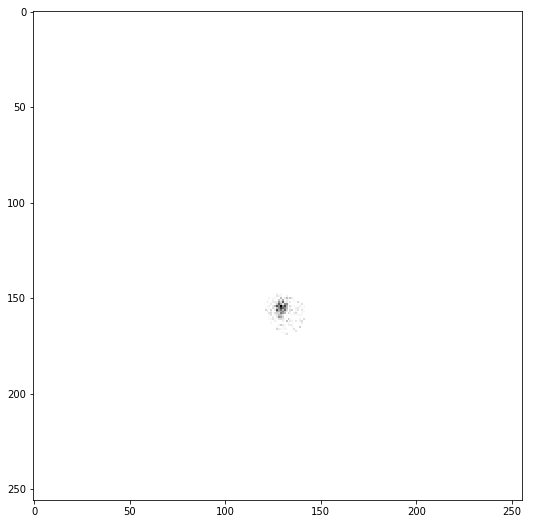

In [6]:
plt.rcParams['figure.figsize'] = (10, 9)
x_widget = ipywidgets.FloatSlider(min=0.0, max=image_data.shape[0], step=1);
interact(lambda(x): plt.imshow(image_data[int(x)], cmap='Greys'),x=x_widget);

In [7]:
basepath = "/data/lisa/data/BRATS2013"
import glob, os
import re

def get_data(glob_pattern, is_labels=False):
    data = {}
    for filename in glob.iglob(glob_pattern):
        print ".",
        path = os.path.normpath(filename).split(os.sep)
        number = list(reversed(path))[2]
        level = list(reversed(path))[3]
        name = level+number

        image_data, image_header = medpy.io.load(filename)
        image_data = image_data.T
        
        if (is_labels):
            image_data = np.round(image_data) #clean up labels
            
        image_data = image_data[:,:,128:] #crop right side
        data[name] = image_data
    return data

flair = get_data(basepath + "/Synthetic_Data/*/*/*/*Flair.*N4ITK.mha")
t1 = get_data(basepath + "/Synthetic_Data/*/*/*/*T1.*N4ITK.mha")
t1c = get_data(basepath + "/Synthetic_Data/*/*/*/*T1c.*N4ITK.mha")
t2 = get_data(basepath + "/Synthetic_Data/*/*/*/*T2.*N4ITK.mha")
labels = get_data(basepath + "/Synthetic_Data/*/*/*/*5more*N4ITK.mha", is_labels=True)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [8]:
#scale between 0 and 1 so we can export it as an image
def normalize_data(data):
    max_val = np.asarray(data.values()).max()
    for k,v in data.iteritems():
        data[k] = v/max_val
    new_max_val = np.asarray(data.values()).max()
    print "normalize", max_val, "->", new_max_val

In [9]:
#normalize inplace
normalize_data(flair)
normalize_data(t1)
normalize_data(t1c)
normalize_data(t2)

normalize 2763.17 -> 1.0
normalize 11040.3 -> 1.0
normalize 4677.01 -> 1.0
normalize 4317.09 -> 1.0


In [10]:
labels['LG0001'].shape

(181, 256, 128)

In [11]:
def get_labels(rightside):
    met = {}
    met["brain"]    = (1.*(rightside!= 0).sum()/(rightside == 0).sum())
    met["tumor"]    = (1.*(rightside > 2).sum()/((rightside != 0).sum() + 1e-10))
    
    met["has_enough_brain"] = met["brain"]     > 0.30
    met["has_tumor"]        = met["tumor"]     > 0.01
    return met

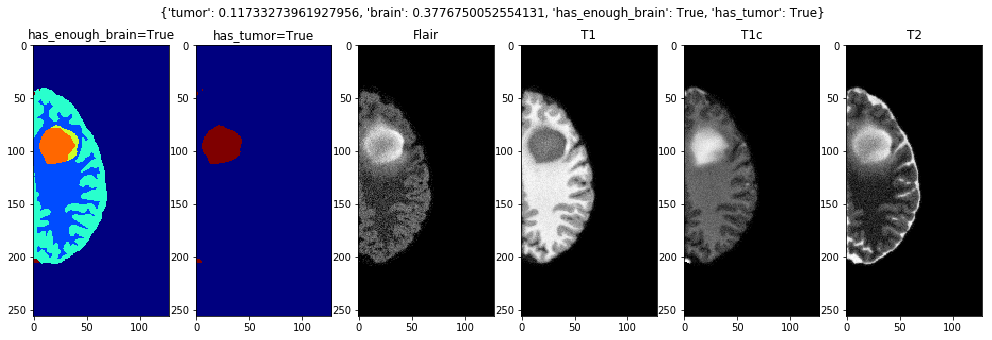

In [12]:
sample = 'HG0001'
slide = 104
label = labels[sample][slide]
fla = flair[sample][slide]
it1 = t1[sample][slide]
it1c = t1c[sample][slide]
it2 = t2[sample][slide]

met = get_labels(label)

plt.rcParams['figure.figsize'] = (17, 9)
fig, axarr = plt.subplots(1,6);
axarr[0].imshow(label);
axarr[0].set_title("has_enough_brain="+ str(met["has_enough_brain"]))
axarr[1].imshow(label > 2);
axarr[1].set_title("has_tumor="+ str(met["has_tumor"]))
axarr[2].imshow(1.0-fla, cmap='Greys');
axarr[2].set_title("Flair")
axarr[3].imshow(1.0-it1, cmap='Greys');
axarr[3].set_title("T1")
axarr[4].imshow(1.0-it1c, cmap='Greys');
axarr[4].set_title("T1c")
axarr[5].imshow(1.0-it2, cmap='Greys');
axarr[5].set_title("T2")

fig.suptitle(met, y=0.77);

In [13]:
# now create a dataframe and compute the label values
dataset = []
for sample in labels.keys():
    for slide in range(labels[sample].shape[0]):
        rightside = labels[sample][slide]
        met = get_labels(rightside)
        met["sample_name"] = sample
        met["slide"] = slide
        dataset.append(met)
        met["flair"] = flair[sample][slide]
        met["t1"] = t1[sample][slide]

In [14]:
stats = pd.DataFrame(dataset)

In [15]:
stats[stats.has_enough_brain].head()

,brain,flair,has_enough_brain,has_tumor,sample_name,slide,t1,tumor
47,0.306904,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,True,HG0018,47,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.269396
48,0.314611,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,True,HG0018,48,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.253889
49,0.321503,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,True,HG0018,49,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.246362
50,0.328630,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,True,HG0018,50,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.239605
51,0.338179,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,True,HG0018,51,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.234513


In [16]:
tostudy = np.random.choice(stats["sample_name"].unique(), 20)

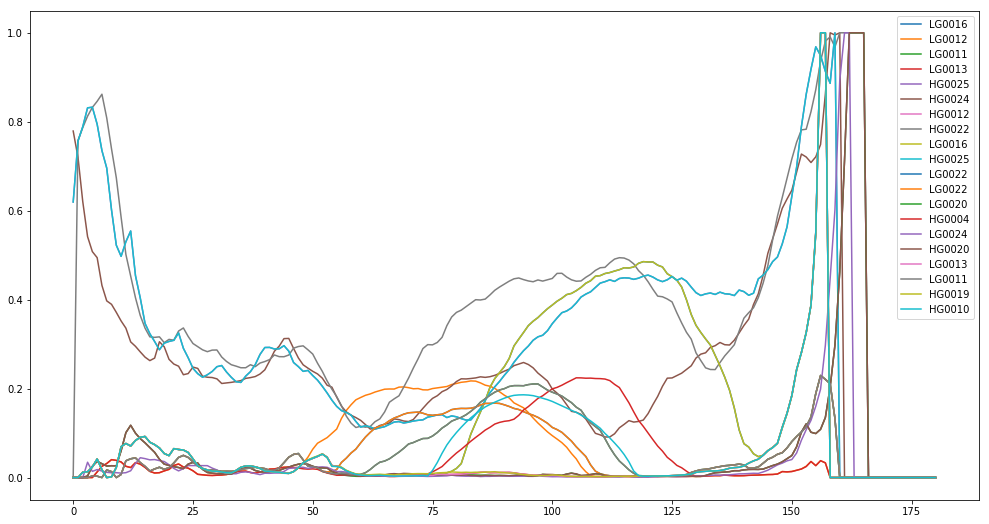

In [17]:
for sample in tostudy:
    plt.plot(stats[stats["sample_name"]==sample].slide, stats[stats["sample_name"]==sample].tumor, label=sample);
plt.legend();

In [18]:
#build dataset

In [19]:
print "Total image slices", stats.shape[0]

Total image slices 9050


In [20]:
base = stats[stats.has_enough_brain]
print "Total image slices with enough brain", base.shape[0]

Total image slices with enough brain 3540


In [21]:
import collections
print "tumor", collections.Counter(base.has_tumor)

tumor Counter({True: 2472, False: 1068})


In [22]:
# split on patients so the classifier is not trained on people in the holdout set.
num_patients = base.sample_name.unique().shape[0]
train_pat = base.sample_name.unique()[:30]
holdout_pat = base.sample_name.unique()[30:]

In [23]:
train = base[base.sample_name.isin(train_pat)]
train.sample_name.unique()

array(['HG0018', 'HG0019', 'HG0012', 'HG0013', 'HG0010', 'HG0011',
       'HG0016', 'HG0017', 'HG0014', 'HG0015', 'HG0023', 'HG0022',
       'HG0021', 'LG0005', 'LG0004', 'LG0007', 'LG0006', 'LG0001',
       'LG0003', 'LG0002', 'LG0025', 'LG0024', 'LG0009', 'LG0022',
       'LG0021', 'LG0020', 'HG0009', 'HG0008', 'HG0002', 'HG0025'], dtype=object)

In [24]:
holdout = base[base.sample_name.isin(holdout_pat)]
holdout.sample_name.unique()

array(['HG0001', 'HG0003', 'HG0024', 'HG0005', 'HG0004', 'HG0007',
       'HG0006', 'HG0020', 'LG0023', 'LG0008', 'LG0016', 'LG0017',
       'LG0014', 'LG0015', 'LG0012', 'LG0013', 'LG0010', 'LG0011',
       'LG0018', 'LG0019'], dtype=object)

In [25]:
print "train raw dist", collections.Counter(train.has_tumor)
print "holtout raw dist", collections.Counter(holdout.has_tumor)

train raw dist Counter({True: 1421, False: 704})
holtout raw dist Counter({True: 1051, False: 364})


In [112]:
def sample_ratio(samples, ratio_with_tumor, dataframe, seed=0):
    np.random.seed(seed)
    
    num_withtumor = int(np.round(samples*ratio_with_tumor))
    num_notumor   = int(np.round(samples*(1.0-ratio_with_tumor)))
    
    with_tumor    = np.random.choice(dataframe[dataframe.has_tumor == True].index, num_withtumor)
    without_tumor = np.random.choice(dataframe[dataframe.has_tumor == False].index, num_notumor)
    
    return dataframe.loc[np.concatenate([with_tumor, without_tumor],axis=0)]

In [113]:
#test things
domaina = sample_ratio(700, 0.5, train)
domainb = sample_ratio(700, 1.0, train)
print "domaina", collections.Counter(domaina.has_tumor)
print "domainb", collections.Counter(domainb.has_tumor)

domaina Counter({False: 350, True: 350})
domainb Counter({True: 700})


In [114]:
domaina.head()

,brain,flair,has_enough_brain,has_tumor,sample_name,slide,t1,tumor
2589,0.384193,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,True,LG0004,55,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.035734
2097,0.360458,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,True,HG0022,106,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.442064
4752,0.303576,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,True,HG0009,46,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.021491
3135,0.428733,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,True,LG0001,58,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.081562
2792,0.459534,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,True,LG0007,77,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.121935


In [115]:
path = "cyclegan/datasets/brats2013-var/"
for i in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    print i
    domainb = sample_ratio(700, i, train)
    print collections.Counter(domainb.has_tumor)
    thispath = path + "brats2013_" + str(i)
    if not os.path.exists(thispath):
        os.makedirs(thispath + "/trainA")
        os.makedirs(thispath + "/testA")
        os.makedirs(thispath + "/trainB")
        os.makedirs(thispath + "/testB")
    print thispath
        
    import skimage
    from skimage.io import imread, imsave

    for i, row in domaina.iterrows():
        imgg = row.flair
        name = str(row["sample_name"]) + "-" + str(row.slide) + "-" + str(row.has_tumor)
        imsave(thispath + "/trainA/" + name + ".png", imgg)
        imsave(thispath + "/testA/" + name + ".png", imgg)

    for i, row in domainb.iterrows():
        imgg = row.t1
        name = str(row["sample_name"]) + "-" + str(row.slide) + "-" + str(row.has_tumor)
        imsave(thispath + "/trainB/" + name + ".png", imgg)
        imsave(thispath + "/testB/" + name + ".png", imgg)
    

0.0
Counter({False: 700})
cyclegan/datasets/brats2013-var/brats2013_0.0
0.1
Counter({False: 630, True: 70})
cyclegan/datasets/brats2013-var/brats2013_0.1
0.2
Counter({False: 560, True: 140})
cyclegan/datasets/brats2013-var/brats2013_0.2
0.3
Counter({False: 490, True: 210})
cyclegan/datasets/brats2013-var/brats2013_0.3
0.4
Counter({False: 420, True: 280})
cyclegan/datasets/brats2013-var/brats2013_0.4
0.5
Counter({False: 350, True: 350})
cyclegan/datasets/brats2013-var/brats2013_0.5
0.6
Counter({True: 420, False: 280})
cyclegan/datasets/brats2013-var/brats2013_0.6
0.7
Counter({True: 490, False: 210})
cyclegan/datasets/brats2013-var/brats2013_0.7
0.8
Counter({True: 560, False: 140})
cyclegan/datasets/brats2013-var/brats2013_0.8
0.9
Counter({True: 630, False: 70})
cyclegan/datasets/brats2013-var/brats2013_0.9
1.0
Counter({True: 700})
cyclegan/datasets/brats2013-var/brats2013_1.0


In [116]:
holdout_bal = sample_ratio(350, 0.5, holdout)

In [117]:
thispath = "cyclegan/datasets/brats2013-var/holdout"
if not os.path.exists(thispath):
        os.makedirs(thispath + "/trainA")
        os.makedirs(thispath + "/trainB")
print thispath

import skimage
from skimage.io import imread, imsave

for i, row in holdout_bal.iterrows():
    imgg = row.flair
    name = str(row["sample_name"]) + "-" + str(row.slide) + "-" + str(row.has_tumor)
    imsave(thispath + "/trainA/" + name + ".png", imgg)
    
for i, row in holdout_bal.iterrows():
    imgg = row.t1
    name = str(row["sample_name"]) + "-" + str(row.slide) + "-" + str(row.has_tumor)
    imsave(thispath + "/trainB/" + name + ".png", imgg)

cyclegan/datasets/brats2013-var/holdout


In [119]:
A_img = holdout_bal[(holdout_bal.sample_name == "HG0001") & (holdout_bal.slide == 103)].flair.as_matrix()[0]

In [120]:
B_img = imread("cyclegan/datasets/brats2013-var/holdout/trainA/HG0001-103-True.png")
B_img = B_img.astype(np.float)
B_img /= 2.0**16

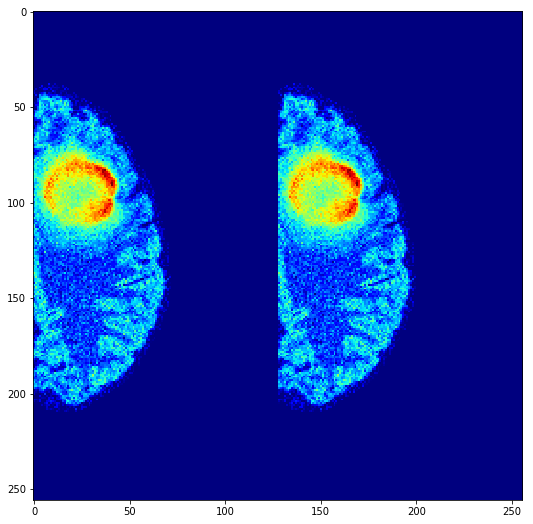

In [121]:
plt.imshow(np.concatenate([A_img, B_img], axis=1))